# Thermodynamic model of an adsorbent-gas-balloon system

In [2]:
import PyPlot; const plt = PyPlot
using Polynomials
using NLsolve
using DataFrames
using CSV
using Optim
using Roots
using DataFrames
using LaTeXStrings
using ForwardDiff
using Statistics
using Printf
PyPlot.matplotlib[:style][:use]("seaborn-colorblind")
PyPlot.matplotlib["rcParams"][:update](["font.size" => 14])

In [3]:
"Create a sketch/mathy figure panel with x, y axes"
function mathy_figure(;bottom_smart_bounds::Bool=true, figsize=(5, 5))
    fig = plt.figure(figsize=figsize)
    ax = fig[:add_subplot](1, 1, 1)

    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax[:spines]["left"][:set_position]("zero")
    ax[:spines]["bottom"][:set_position]("zero")

    # Eliminate upper and right axes
    ax[:spines]["right"][:set_color]("none")
    ax[:spines]["top"][:set_color]("none")
    
    # magic to prevent overlapping content
    # see https://matplotlib.org/examples/pylab_examples/spine_placement_demo.html
    ax[:spines]["left"][:set_smart_bounds](true)
    if bottom_smart_bounds
        ax[:spines]["bottom"][:set_smart_bounds](true)
    end
    
    ax[:xaxis][:set_ticks_position]("bottom")
    ax[:yaxis][:set_ticks_position]("left")
    
    return fig, ax
end

mathy_figure

## Description of components
We describe the rubber balloon, adsorbent, and gas model separately.

### Gas: the ideal gas law

In [4]:
const R = 8.3144598e-5 # m³-bar/(K-mol)

8.3144598e-5

### Rubber ballon: the 8-chain Arruda-Boyce model

Langevin and inverse Langevin functions; see [here](https://en.wikipedia.org/wiki/Brillouin_and_Langevin_functions).

In [5]:
langevin(ϕ::Float64) = coth(ϕ) - 1.0 / ϕ

# don't type assert for ForwardDiff
inverse_langevin_cohen_approx(ϕ) = ϕ * (3 - ϕ ^ 2) / (1 - ϕ ^ 2) 

inverse_langevin_cohen_approx (generic function with 1 method)

In [6]:
"""
Strain energy density for 8-chain Arruda Boyce model under biaxial tension.

Parameters from "Constitutive Models of Rubber Elasticity: A Review" 
by Boyce & Arruda are given as n = 26.5 and ρkT = 0.27 MPa = 2.7 bar.

# Arguments
* λ::Float64: stretch factor
* n::Int: number of monomers in each freely jointed chain
* ρkT::Float64: density of chains ρ times kB T (units: bar = force/area = energy/volume)

# Returns
energy per volume = force * length / (length ³) = force / area = pressure
"""
function membrane_strain_energy_density(λ, n::Float64, ρkT::Float64)
    # don't type assert λ for ForwardDiff
    I = 2 * λ ^ 2 + 1 / λ ^ 4
    
    x_ovr_nb = sqrt(I) / sqrt(3 * n)
    
    Ł⁻¹ = inverse_langevin_cohen_approx(x_ovr_nb)
    
    return ρkT * n * (x_ovr_nb * Ł⁻¹ + log(Ł⁻¹ / sinh(Ł⁻¹))) # energy per volume = pressure
end

membrane_strain_energy_density

In [7]:
"""
Data structure describing balloon, whose membrane, under biaxial tension,
is modeled with 8-chain Arruda Boyce model.
"""
struct Balloon
    r₀::Float64 # radius at rest (length)
    z₀::Float64 # thickness at rest (length)
    n::Float64 # length of freely jointed chains comprising the balloon membrane
    ρkT::Float64 # density of chains ρ times kB T (units: bar)
end

"""
Given a balloon whose ρkT is evaluated at T₀, 
construct a balloon at a new temperature T.
"""
function new_balloon(balloon::Balloon, T₀::Float64, T::Float64)
    # r₀ and z₀ shld stay same under assumption of incompressibility
    # at rest, expected chain length is b*sqrt(n) under random walk regardless of temperature
    return Balloon(balloon.r₀, balloon.z₀, balloon.n, balloon.ρkT * T / T₀)
end

new_balloon

In [8]:
"""
Surface tension for balloon described by 8-chain Arruda Boyce model.

Parameters from "Constitutive Models of Rubber Elasticity: A Review" 
by Boyce & Arruda are given as n = 26.5 and ρkT = 0.27 MPa = 2.7 bar.

# Arguments
* r::Float64: radius of the balloon
* balloon::Balloon: balloon, described by radius and thickness when undeformed/uninflated
* n::Int: number of monomers in each freely jointed chain comprising the balloon membrane
* ρkT::Float64: density of chains ρ times kB T (units: bar)

# Returns
energy per area
"""
function surface_tension(r::Float64, balloon::Balloon)
    # normalized radius
    λ = r / balloon.r₀
    # build free energy function (units: energy)
    W(λ) = membrane_strain_energy_density(λ, balloon.n, balloon.ρkT)
    # σ = ∂F/∂A
    #    area A = 2 * (4π (r₀λ)²) # inside and outside is convention
    #        dA = 16 π r₀² λ dλ
    #    volume V = 4 * π * r₀ ^ 2 * z₀, invariant under incompressibility
    return balloon.z₀ * ForwardDiff.derivative(W, λ) / (4 * λ)
end

surface_tension

In [9]:
function moles_of_gas_in_balloon(balloon::Balloon, r::Float64, P₀::Float64, T::Float64)
    # calculate gas pressure inside to balance membrane tension, P = P₀ + 4 σ /r
    P = P₀ + 4.0 * surface_tension(r, balloon) / r # bar
    # volume inside balloon for gas
    volume_gas_in_balloon = 4 / 3 * π * r ^ 3
    return P * volume_gas_in_balloon / (R * T)
end

moles_of_gas_in_balloon (generic function with 1 method)

### Adsorbent, the Langmuir model

In [10]:
const R_kJ_mol_K = 8.3144598 / 1000.0 # kJ/(mol-K)

0.0083144598

In [11]:
function langmuir_adsorption(P::Float64, K::Float64, M::Float64)
    return M * K * P / (1 + K * P) # moles of gas
end

langmuir_adsorption (generic function with 1 method)

In [12]:
struct LangmuirAdsorbent
    # Langmuir constant at reference temperature (1 / bar)
    K0::Float64
    # reference temperature T0 (K)
    T0::Float64
    # saturation loading (mol)
    M::Float64 
    # isosteric heat of adsorption (kJ/mol), for extrapolating Langmuir adsorption isotherm.
    Qst::Float64
end

Construct adsorbent

In [13]:
adsorbent = LangmuirAdsorbent(1.0, 298.0, 1.0, 30.0)

LangmuirAdsorbent(1.0, 298.0, 1.0, 30.0)

This extrapolates the Langmuir constant for an adsorbent to different temperatures.

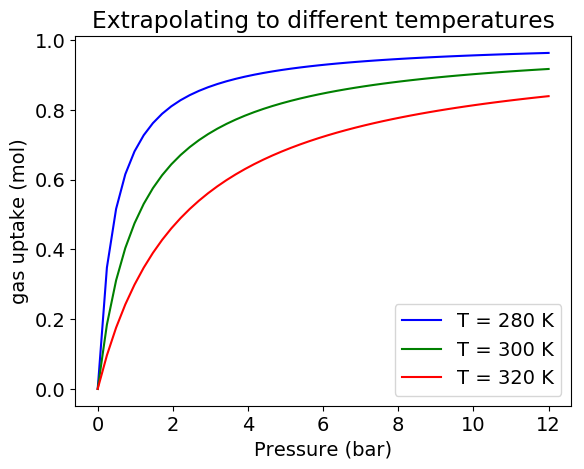

In [14]:
"""
Extrapolate the Langmuir constant of an adsorbent to a different temperature.
Use the heat of adsorption and eqn (2) in http://www.seas.upenn.edu/~amyers/CHAPTER21.pdf
"""
function langmuir_constant(adsorbent::LangmuirAdsorbent, T::Float64)
    return adsorbent.K0 * exp(adsorbent.Qst / R_kJ_mol_K * (1.0 / T - 1.0 / adsorbent.T0))
end

function langmuir_adsorption(adsorbent::LangmuirAdsorbent, P::Float64, T::Float64)
    K = langmuir_constant(adsorbent, T)
    return langmuir_adsorption(P, K, adsorbent.M)
end

fig = plt.figure()
P = collect(range(0.0, stop=12.0, length=50))
Ts = [280.0, 300.0, 320.0]
colors = ["b", "g", "r"]
for (i, T) in enumerate(Ts)
    plt.plot(P, [langmuir_adsorption(adsorbent, p, T) for p in P], 
             label=@sprintf("T = %.0f K", T), color=colors[i])
end
plt.legend(loc="lower right")
plt.xlabel("Pressure (bar)")
plt.ylabel("gas uptake (mol)")
plt.title("Extrapolating to different temperatures")
plt.show()

# Balloon-adsorbent system

In [15]:
mutable struct System
    N::Float64 # total moles of gas (mol)
    T::Float64 # temperature (K)
    P₀::Float64 # pressure outside of balloon (bar)
end

function solve_balloon_adsorbent(adsorbent::LangmuirAdsorbent, 
                                 balloon::Balloon, 
                                 system::System;
                                 nb_pts::Int=1000)
    function distance_from_mass_conservation(r_ovr_r₀::Float64)
        # radius of balloon (m)
        r = balloon.r₀ * r_ovr_r₀
        # volume for gas in balloon (m³)
        Vb = 4 / 3 * π * r ^ 3
        # pressure of gas in the balloon (bar)
        P = system.P₀ + 4.0 * surface_tension(r, balloon) / r
        # moles of gas in the balloon
        Nb = P * Vb / (R * system.T)
        # moles of gas in the adsorbent
        Nₐ = langmuir_adsorption(adsorbent, P, system.T)
        return system.N - Nₐ - Nb # should zero
    end
    
    # get all zeros with fzeros with an "s".
    r_ovr_r₀_opts = fzeros(distance_from_mass_conservation, 0.0, 6.4, 
                           no_points=nb_pts)
    
    # return solutions as a dictionary (may be 1 or 3!)
    solns = []
    for i = 1:length(r_ovr_r₀_opts)
        soln = Dict{String, Float64}()
        soln["r"] = r_ovr_r₀_opts[i] * balloon.r₀
        soln["P"] = system.P₀ + 4.0 * surface_tension(soln["r"], balloon) / soln["r"] # bar
        soln["N_a"] = langmuir_adsorption(adsorbent, soln["P"], system.T)
        soln["N_b"] = system.N - soln["N_a"]
        if soln["P"] > system.P₀
            push!(solns, soln)
        end
    end
    return solns
end

solve_balloon_adsorbent (generic function with 1 method)

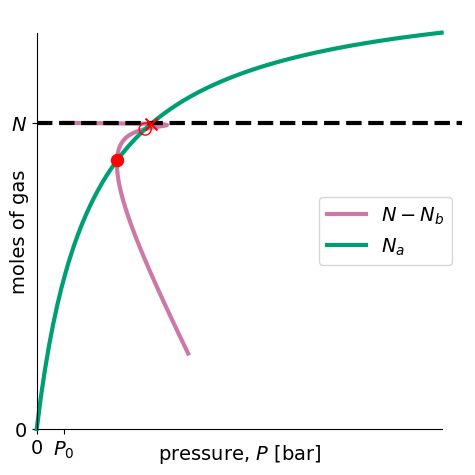

In [20]:
system = System(30.0, 298.0, 0.1)
balloon = Balloon(0.1, 0.01, 30.0, 3.0) # ballpark params
adsorbent = LangmuirAdsorbent(5.0, 298.0, 44.0, 30.0)

Pa = collect(range(0, 1.5, length=100))
Na = [langmuir_adsorption(adsorbent, p, system.T) for p in Pa]

normalized_radius = collect(range(1.0, stop=6.2, length=100)) # r/r₀
Nb = similar(normalized_radius)
Pb = similar(normalized_radius)
for i = 1:length(normalized_radius)
    r = balloon.r₀ * normalized_radius[i]
    Pb[i] = system.P₀ + 4.0 * surface_tension(r, balloon) / r # bar
    Nb[i] = moles_of_gas_in_balloon(balloon, r, system.P₀, system.T)
end

solns = solve_balloon_adsorbent(adsorbent, balloon, system)

fig, ax = mathy_figure()

plt.plot(Pb, system.N .- Nb, label="\$N - N_b\$",
        color="C3", lw=3)
plt.plot(Pa, Na, color="C1", label="\$N_a\$", lw=3)
plt.axhline(system.N, color="k", linestyle="--", lw=3, xmin=0.045)
# # Gibbs free energies
# Gs = [gibbs_free_energy(balloon, adsorbent, system, 
#                            sol["r"], sol["N_a"] / system.N) for sol in solns]
# @assert(Gs[1] < Gs[2], "id 2 not saddle!")
# @assert(Gs[3] < Gs[1], "id 3 not stable, with id 1 metastable!")

for (i_sol, sol) in enumerate(solns)
#     println("G = ", gibbs_free_energy(balloon, adsorbent, system, 
#                            sol["r"], sol["N_a"] / system.N))
    if i_sol == 2
        plt.scatter(sol["P"], 
                    sol["N_a"],
                    color="r", facecolors="none", edgecolors="r",
                    zorder=2000, s=75)
    else
        plt.scatter(sol["P"],
                    sol["N_a"],
                    marker=(i_sol == 1) ? "x" : "o",
                    color="r", zorder=2000, s=75)
    end
end
# plt.plot(r_ovr_r_0, P_minus_P0_autodiff, color="k", linestyle="--")
plt.xlabel("pressure, \$P\$ [bar]", labelpad=-13)
plt.ylabel("moles of gas", labelpad=-13)
plt.yticks([0, system.N], ["\$0\$", "\$N\$"])
# plt.axvline(x=system.P₀, linestyle=":", color="k")
plt.xticks([0, system.P₀], ["\$0\$", "\$P_0\$"])
plt.legend(loc="center right")
# plt.title("Pressure-radius characteristic of balloon")
plt.tight_layout()
plt.savefig("balloon_isotherm.png", format="png", dpi=300)
plt.show()

Gas partitioning between adsorbed/gas phase

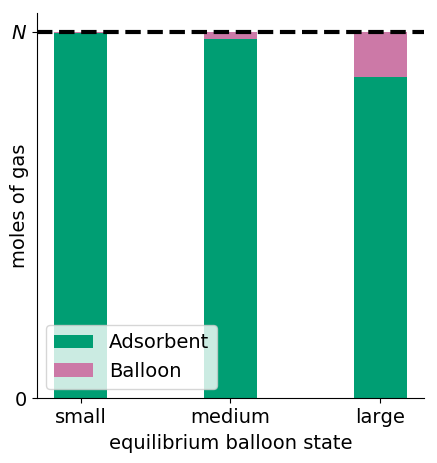

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = fig[:add_subplot](1, 1, 1)
nb_solns = length(solns)
ax[:spines]["right"][:set_color]("none")
ax[:spines]["top"][:set_color]("none")
plt.axhline(system.N, color="k", linestyle="--", lw=3)
width = 0.35 # the width of the bars: can also be len(x) sequence
p1 = plt.bar(1:nb_solns, [soln["N_a"] for soln in solns], width, 
            color="C1", label="Adsorbent")
p2 = plt.bar(1:nb_solns, [soln["N_b"] for soln in solns], width,
             bottom=[soln["N_a"] for soln in solns], label="Balloon", 
            color="C3")
plt.xticks(1:nb_solns, ["small", "medium", "large"])
plt.xlabel("equilibrium balloon state", labelpad=5)
plt.ylabel("moles of gas", labelpad=-13)
plt.yticks([0, system.N], ["\$0\$", "\$N\$"])
plt.legend(loc="lower left")
plt.savefig("gas_partitioning.png", format="png", dpi=300)

In [34]:
function draw_balloon_characteristics(balloon::Balloon, system::System)
    normalized_radius = collect(range(1.0, stop=6.3, length=100)) # r/r₀
    pressure_jump = similar(normalized_radius)
    Nb = similar(normalized_radius)
    for i = 1:length(normalized_radius)
        r = balloon.r₀ * normalized_radius[i]
        pressure_jump[i] = 4.0 * surface_tension(r, balloon) / r # bar
        Nb[i] = moles_of_gas_in_balloon(balloon, r, system.P₀, system.T)
    end
    
    # pressure-radius characteristic
    fig, ax = mathy_figure(bottom_smart_bounds=false)
    plt.plot(normalized_radius, pressure_jump, color="g", lw=3)
    plt.xlabel("balloon radius, \$r/r_0\$", labelpad=-13)
    plt.ylabel("pressure jump, \$P-P_0\$", labelpad=-13)
    plt.xlim(xmin=0.0)
    # plt.ylim(ymin=0.0)
    plt.yticks([0])
    plt.xticks([1])
    plt.tight_layout()
    # plt.title("Pressure-radius characteristic of balloon")
    plt.savefig("pressure_radius_characteristic_balloon.png", format="png")
    plt.show()
    
    # analogy of adsorption isotherm for balloon
    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=1.0, 
                                                  vmax=maximum(normalized_radius))

    m = plt.cm[:ScalarMappable](norm=cnorm, cmap=plt.cm[:viridis])
    m[:set_array]([]) # trick

    fig, ax = mathy_figure(bottom_smart_bounds=true, figsize=(6.5, 5))
    for i = 1:length(normalized_radius)-1
        plt.plot(Nb[i:i+1], pressure_jump[i:i+1] .+ system.P₀,
                 lw=3,
                 c=m[:to_rgba](mean(normalized_radius[i:i+1])))
    end
    plt.yticks([0.0, system.P₀], ["\$0\$", "\$P_0\$"])
    plt.xticks([0], ["0"])
    cbar = plt.colorbar(m, label="balloon radius, \$r/r_0\$")
    plt.plot([0], [0])
    cbar[:ax][:set_yticklabels]([1])
    plt.xlabel("gas in balloon, \$N_b\$", labelpad=-13)
    plt.ylabel("pressure, \$P\$", labelpad=-13)
    plt.tight_layout()
    plt.savefig("pressure_radius_moles.png", format="png", dpi=300)
end

draw_balloon_characteristics (generic function with 1 method)

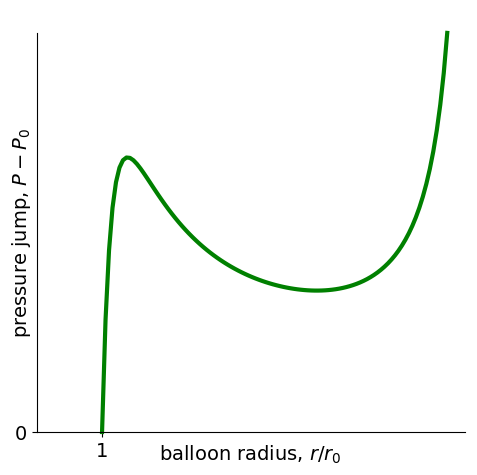

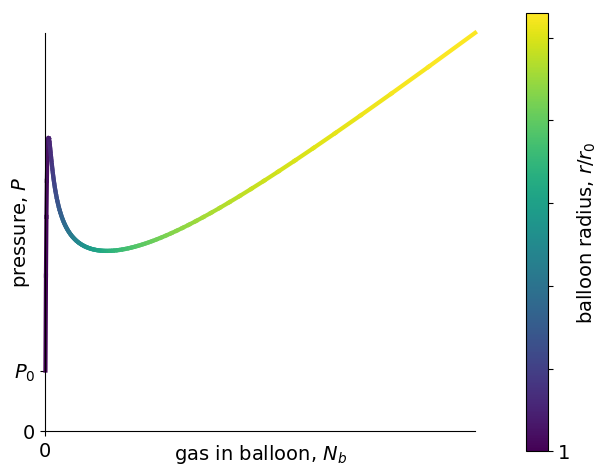

In [35]:
draw_balloon_characteristics(balloon, system)

bifurcation diagram

In [36]:
function get_bifurcation_data(adsorbent::LangmuirAdsorbent, balloon::Balloon, system::System,
                              N_min::Float64, N_max::Float64, nb_pts::Int)  
    N_span = collect(range(N_min, stop=N_max, length=nb_pts))
    df_bifur = DataFrame(N=Float64[], r=Float64[], P=Float64[], which_soln=String[])
    
    new_system = deepcopy(system)

    which_soln = "small" # low N, start in small regime
    for j = 1:nb_pts
        new_system.N = N_span[j]
        soln = solve_balloon_adsorbent(adsorbent, balloon, new_system, nb_pts=nb_pts)        
        if length(soln) == 2
            println("Woops, fzeros only found 2 solns. increase no_points in it to get finer resolution")
            continue
        end
        
        if length(soln) == 3
            rs = [sol["r"] for sol in soln]
            Ps = [sol["P"] for sol in soln]

            id_min = argmin(rs)
            id_max = argmax(rs)
            id_med = filter(x -> !(x in [id_min, id_max]), [1, 2, 3])[1]

            push!(df_bifur, [N_span[j],  soln[id_min]["r"], soln[id_min]["P"], "small"])
            push!(df_bifur, [N_span[j],  soln[id_med]["r"], soln[id_med]["P"], "medium"])
            push!(df_bifur, [N_span[j],  soln[id_max]["r"], soln[id_max]["P"], "large"])

            which_soln = "large" # for when go to nb_soln = 1
        elseif length(soln) == 1
            push!(df_bifur, [N_span[j],  soln[1]["r"], soln[1]["P"], which_soln])
        end
    end
    return df_bifur
end

df_bifur = get_bifurcation_data(adsorbent, balloon, system, 0.8*system.N, 1.2*system.N, 250)
first(df_bifur, 6)

,N,r,P,which_soln
,Float64,Float64,Float64,String
1,24.0,0.104621,0.238984,small
2,24.0482,0.104664,0.240037,small
3,24.0964,0.104708,0.241094,small
4,24.1446,0.104752,0.242156,small
5,24.1928,0.104797,0.243223,small
6,24.241,0.104842,0.244296,small


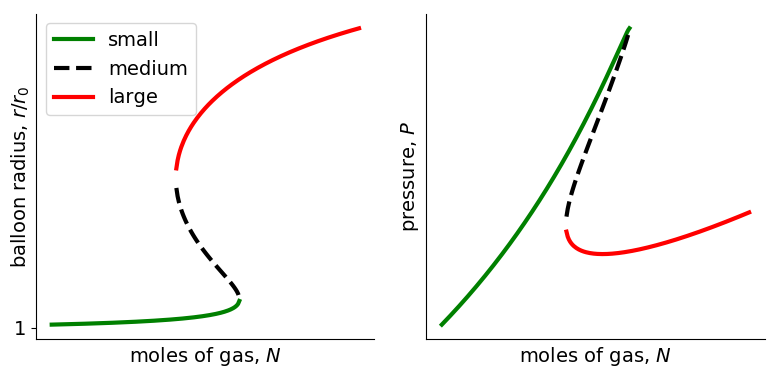

In [39]:
function plot_bifurcation_diagram(df_bifur::DataFrame; savename=Union{Void, String}=nothing)
    fig = plt.figure(figsize=(8, 4))

    soln_colors = Dict("small" => "g", "medium" => "k", "large" => "r")
    soln_linestyle = Dict("small" => nothing, "medium" => "--", "large" => nothing)

    ax = plt.subplot(1, 2, 1)
    ax[:spines]["right"][:set_color]("none")
    ax[:spines]["top"][:set_color]("none")
    for soln in ["small", "medium", "large"]
        plt.plot(df_bifur[:N][df_bifur[:which_soln] .== soln],
                 df_bifur[:r][df_bifur[:which_soln] .== soln] / balloon.r₀, 
                 color=soln_colors[soln], linestyle=soln_linestyle[soln], label=soln, lw=3)
    end

    # plt.axvline(x=N_upper_limit)
    # plt.axvline(x=N_lower_limit)
    plt.xticks([])
    plt.yticks([1.0])
    plt.xlabel("moles of gas, \$N\$")
    plt.ylabel("balloon radius, \$r/r_0\$", labelpad=-13)
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax[:spines]["right"][:set_color]("none")
    ax[:spines]["top"][:set_color]("none")
    for soln in ["small", "medium", "large"]
        plt.plot(df_bifur[:N][df_bifur[:which_soln] .== soln],
                 df_bifur[:P][df_bifur[:which_soln] .== soln], 
                 color=soln_colors[soln], linestyle=soln_linestyle[soln], lw=3)
    end
    plt.xticks([])
    plt.yticks([])
    # plt.axvline(x=N_upper_limit)
    # plt.axvline(x=N_lower_limit)
    plt.xlabel("moles of gas, \$N\$")
    plt.ylabel("pressure, \$P\$")
   # plt.legend()
    plt.tight_layout()
    if savename != nothing
        plt.savefig(savename * ".png", format="png", dpi=300)
    end
end

plot_bifurcation_diagram(df_bifur, savename="bifurcation")

# Two connected adsorbents

In [40]:
function solve_two_adsorbents(a1::LangmuirAdsorbent, 
                              a2::LangmuirAdsorbent, 
                              N::Float64,
                              T::Float64)
    function mk_this_zero(P::Float64)
        N1 = langmuir_adsorption(a1, P, T)
        N2 = langmuir_adsorption(a2, P, T)
        return N - N1 - N2
    end
    
    P_opt = fzero(mk_this_zero, 0.0, 3.0)
    
    return P_opt
end

solve_two_adsorbents (generic function with 1 method)

construct adsorbents and define total amount of gas in the system.

In [41]:
a1 = LangmuirAdsorbent(1.0, 298.0, 1.0, 0.0)
a2 = LangmuirAdsorbent(7.0, 298.0, 1.5, 0.0)
N = 1.5

1.5

Find equilibrium solution, plot graphical solution.

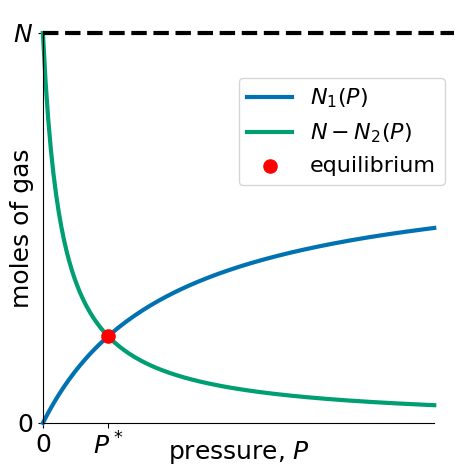

In [42]:
P_opt = solve_two_adsorbents(a1, a2, N, 298.0)

P = collect(range(0, stop=3, length=150))
N_1 = [langmuir_adsorption(a1, p, system.T) for p in P]
N_2 = [langmuir_adsorption(a2, p, system.T) for p in P]
N_1_opt = langmuir_adsorption(a1, P_opt, system.T)

# fig = plt.figure()
fig, ax = mathy_figure()
plt.plot(P, N_1, lw=3, label="\$N_1(P)\$", color="C0")
plt.plot(P, N .- N_2, lw=3, label="\$N-N_2(P)\$", color="C1")
plt.scatter([P_opt], [N_1_opt], marker="o", color="r", 
    zorder=1000, s=90, label="equilibrium")
plt.xlabel("pressure, \$P\$", fontsize=18, labelpad=-15)
plt.ylabel("moles of gas", fontsize=18, labelpad=-15)
plt.yticks([0, N], ["\$0\$", "\$N\$"], fontsize=18)
plt.xticks([0, P_opt], ["\$0\$", "\$P^*\$"], fontsize=18)
plt.legend(loc=(0.5, 0.6), prop=Dict("size" => 16))
plt.axhline(y=N, c="k", linestyle="--", lw=3, xmin=0.045)
plt.tight_layout()
plt.savefig("two_adsorbents_soln.png", format="png", dpi=300)

## Gibbs free energy
* $\phi$ is fraction of gas in the adsorbed phase.
* $r$ is ofc radius of balloon

r/r₀ = 1.174503, N/Na = 0.996134. G = 0.874475 bar-m3
r/r₀ = 2.090171, N/Na = 0.979319. G = 0.875473 bar-m3
r/r₀ = 4.191106, N/Na = 0.876701. G = 0.869832 bar-m3
min G = 1.000000 at r/r₀ = 4.195489, ϕ = 0.876247
See 

┌ Warning: User must amend balloon.ρkT for different temperatures; use plt.figure() before this
└ @ Main In[44]:37


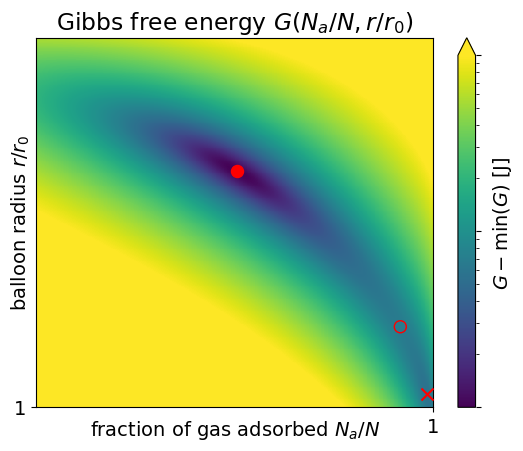

Gibbs_in_plane


PyObject <matplotlib.collections.QuadMesh object at 0x7f4e6b123da0>

In [44]:
function gibbs_free_energy(balloon::Balloon, adsorbent::LangmuirAdsorbent, system::System, 
                           r::Float64, ϕ::Float64)
    # free volume for gas in balloon.
    V_b = 4 / 3 * π * r ^ 3 # m^3

    G = 0.0
    
    # expansion work (bar - m3)
    G += system.P₀ * V_b
    
    # strain energy of membrane (bar - m3)
    W = membrane_strain_energy_density(r / balloon.r₀, balloon.n, balloon.ρkT)
    G += W * (4 * π * balloon.r₀ ^ 2 * balloon.z₀) # volume is surface area times thickness (invariant) 
    
    # moles of gas in adsorbent (a) and balloon (b)
    N_a = ϕ * system.N
    N_b = (1 - ϕ) * system.N
    
    # ideal gas in balloon [m³-bar/(K-mol)] (mol -K)
    G += - N_b * R * system.T * (1.0 + log(V_b / N_b))
    
    # gas in adsorbent
    θ = N_a / adsorbent.M # fractional occupancy of adsorption sites
    # extrapolate langmuir constant
    K = langmuir_constant(adsorbent, system.T)
    G += -R * system.T * (-adsorbent.M * log(1.0 - θ) - N_a * log(θ / (1.0 - θ)) + N_a * log(R * system.T * K))
    return G # bar - m3
end

function plot_Gibbs_free_energy(balloon::Balloon, adsorbent::LangmuirAdsorbent, system::System; 
                                savename::Union{String, Nothing}=nothing, plot_soln::Bool=true, 
                                add_ylabel::Bool=true, add_colorbar::Bool=true,
                                title::String="Gibbs free energy \$G(N_a/N, r / r_0)\$", 
                                vmax::Float64=0.05,
                                ϕ_min::Float64=0.5,
                                r_ovr_r₀_max::Float64=6.0)
    @warn("User must amend balloon.ρkT for different temperatures; use plt.figure() before this")
    # define parameter space to explore
    ϕ = range(ϕ_min, stop=.99999, length=500)
    r = range(balloon.r₀, stop=balloon.r₀ * r_ovr_r₀_max, length=400)
    
    # preallocate G
    G = zeros(Float64, length(ϕ), length(r))

    for i = 1:length(ϕ)
        for j = 1:length(r)
            G[i, j] = gibbs_free_energy(balloon, adsorbent, system, r[j], ϕ[i])
        end
    end
    G *= 1000.0 # bar-m3 to J
    
    G = G .- minimum(G) .+ 1.0
    if sum(isnan.(G)) > 0
        print("NANs in G!")
    end
    
    if plot_soln
        soln = solve_balloon_adsorbent(adsorbent, balloon, system)
        for s in soln
            g_here = gibbs_free_energy(balloon, adsorbent, system, s["r"], s["N_a"]/system.N)
            @printf("r/r₀ = %f, N/Na = %f. G = %f bar-m3\n", s["r"]/balloon.r₀, s["N_a"]/system.N, g_here)
        end
    end
    
    R = similar(collect(transpose(G)))
    Φ = similar(collect(transpose(G)))

    for i = 1:length(r)
        Φ[i, :] = ϕ
    end

    for i = 1:length(ϕ)
        R[:, i] = r / balloon.r₀
    end
    
    @printf("min G = %f at r/r₀ = %f, ϕ = %f\n" , minimum(G), 
                                                  R[argmin(collect(transpose(G)))], 
                                                  Φ[argmin(collect(transpose(G)))])

    img = plt.pcolormesh(Φ, R, collect(transpose(G)), cmap="viridis", 
                         norm=PyPlot.matplotlib[:colors][:LogNorm](vmin=1.0, vmax=100.0))

    if add_colorbar
        cbar = plt.colorbar(extend="max", label="\$G-\\mathrm{min}(G)\$ [J]")
        cbar[:ax][:set_yticklabels]([])
    end
 #   cbar.set_label("bar-m\$^3\$")

    # from exact soln.
    if plot_soln
        if length(soln) == 3
            Gs = [gibbs_free_energy(balloon, adsorbent, system, 
                           sol["r"], sol["N_a"] / system.N) for sol in soln]
            @assert(Gs[1] < Gs[2], "id 2 not saddle!")
            @assert(Gs[3] < Gs[1], "id 3 not stable, with id 1 metastable!")
        end
        for (i_sol, sol) in enumerate(soln)
            if i_sol == 2
                plt.scatter(sol["N_a"] / system.N, 
                            sol["r"] / balloon.r₀,
                            color="r", facecolors="none", edgecolors="r", 
                            clip_on=false, zorder=200, s=75)
            else
                plt.scatter(sol["N_a"] / system.N, 
                            sol["r"] / balloon.r₀,
                            marker=((i_sol == 1) && (length(soln) == 3)) ? "x" : "o",
                            color="r", clip_on=false, zorder=201, s=75)
            end
        end
    end
    plt.xlim([minimum(ϕ), 1.0])
    plt.ylim(ymin=1.0)
    plt.xticks([1.0])
    plt.yticks([1.0])
    plt.xlabel("fraction of gas adsorbed \$N_a / N\$", labelpad=-13)
    if add_ylabel
        plt.ylabel("balloon radius \$r/r_0\$", labelpad=-13)
    end
    plt.title(title)
    
    if savename != nothing
        plt.savefig(savename * ".pdf", format="pdf")
        println("See ", savename)
    end
    return img
end

plt.figure()
plot_Gibbs_free_energy(balloon, adsorbent, system, 
                      savename="Gibbs_in_plane", 
                      ϕ_min=0.75, vmax=1.0)

### Instability with temperature (graphical proof)

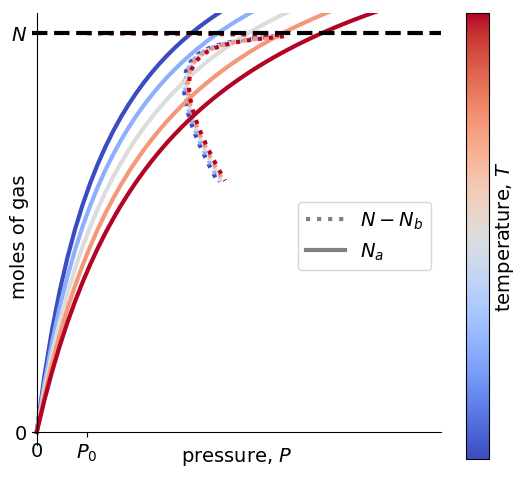

/home/simoncor/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/simoncor/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/simoncor/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
No handles with labels found to put in legend.


In [45]:
temperatures = collect(range(290, stop=305, length=5))
P_max = 1.5
cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=minimum(temperatures), 
                                               vmax=maximum(temperatures))

m = plt.cm[:ScalarMappable](norm=cnorm, cmap=plt.cm[:coolwarm])
m[:set_array]([])

# graphical soln
fig, ax = mathy_figure(figsize=(5.75, 5))
plt.xlabel("pressure, \$P\$", labelpad=-13)
plt.ylabel("moles of gas", labelpad=-13)
for T in temperatures
    # plot adsorption isotherm
    P = collect(range(0, stop=P_max, length=100))
    Na = [langmuir_adsorption(adsorbent, p, T) for p in P]
    plt.plot(P, Na, c=m[:to_rgba](T), lw=3)

    # plot N-N_b
    # hot/cold balloon
    hot_or_cold_balloon = new_balloon(balloon, system.T, T)
    r_ovr_r_0 = range(1.0, stop=5.65, length=100)
    P = similar(r_ovr_r_0)
    Nb = similar(r_ovr_r_0)
    for i = 1:length(r_ovr_r_0)
        r = balloon.r₀ * r_ovr_r_0[i]
        P[i] = system.P₀ .+ 4 * surface_tension(r, hot_or_cold_balloon) / r # bar
        Nb[i] = P[i] * (4 / 3 * π * r ^ 3) / (R *T)
    end

    plt.plot(P, system.N .- Nb, color=m[:to_rgba](T), linestyle=":", lw=3)
    #plt.scatter(0.0, N / adsorbent.K, color="r", marker="x")
end

cbar = plt.colorbar(m, label="temperature, \$T\$", ticks=[])

plt.axhline(y=system.N, color="k", linestyle="--", lw=3)
plt.legend(loc="upper left")
plt.tight_layout()
plt.yticks([0, system.N], ["\$0\$", "\$N\$"])
plt.ylim(ymax=1.05 * system.N)
plt.xticks([0, system.P₀], ["\$0\$", "\$P_0\$"])
plt.xlim([-0.01, 0.8])
# hack for custom legend
plt.plot([-1], [-1], lw=3, linestyle=":", label="\$N-N_b\$", color="0.5")
plt.plot([-1], [-1], lw=3, label="\$N_a\$", color="0.5")

plt.legend(loc="center right")
plt.tight_layout()

plt.savefig("temperature_instability.png", format="png", dpi=300)

plt.show()

r/r₀ = 1.080328, N/Na = 0.997775. G = 0.629734 bar-m3
min G = 1.000000 at r/r₀ = 1.075188, ϕ = 0.997986


┌ Warning: User must amend balloon.ρkT for different temperatures; use plt.figure() before this
└ @ Main In[44]:37
┌ Warning: User must amend balloon.ρkT for different temperatures; use plt.figure() before this
└ @ Main In[44]:37


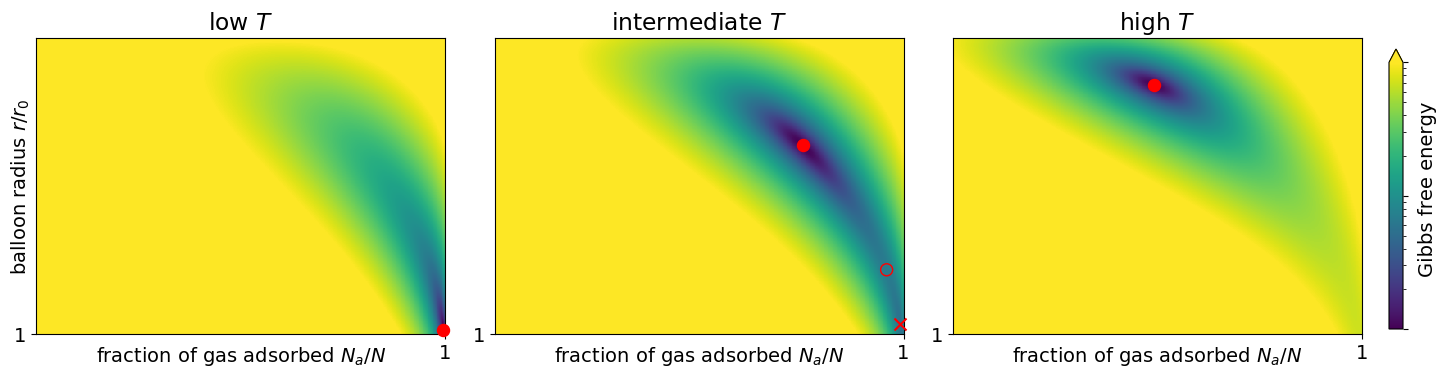

r/r₀ = 1.174503, N/Na = 0.996134. G = 0.874475 bar-m3
r/r₀ = 2.090171, N/Na = 0.979319. G = 0.875473 bar-m3
r/r₀ = 4.191106, N/Na = 0.876701. G = 0.869832 bar-m3
min G = 1.000000 at r/r₀ = 4.195489, ϕ = 0.876746
r/r₀ = 5.218739, N/Na = 0.745578. G = 1.171012 bar-m3
min G = 1.000000 at r/r₀ = 5.223058, ϕ = 0.745486


┌ Warning: User must amend balloon.ρkT for different temperatures; use plt.figure() before this
└ @ Main In[44]:37


In [46]:
fig, axes = plt.subplots(figsize=(14, 4), sharex=true, sharey=true)
#fig = plt.figure(figsize=(10, 3))
#ax = fig[:add_subplot](111) 
#plt.xlabel("\$\\phi := N_a / N\$")
temps = [290.0, 298.0, 310.0]
names = ["low \$T\$", "intermediate \$T\$", "high \$T\$"]

img = []
for i_T = 1:length(temps)
    sys = deepcopy(system)
    sys.T = temps[i_T]
    
    hot_or_cold_balloon = new_balloon(balloon, system.T, temps[i_T])
    
    plt.subplot(1, length(temps), i_T)
    img = plot_Gibbs_free_energy(hot_or_cold_balloon, adsorbent, sys, add_colorbar=false, 
                                title=names[i_T], add_ylabel=(i_T == 1),
                                vmax=100.0
    )
end
# cbar = plt.colorbar(img, extend="max", use_gridspec=true, label="Gibbs free energy")
# cbar[:ax][:set_yticklabels]([])
fig[:subplots_adjust](right=0.95)
cbar_ax = fig[:add_axes]([1.0, 0.15, 0.01, 0.7])

cbar = fig[:colorbar](img, cax=cbar_ax, extend="max", 
    use_gridspec=true, label="Gibbs free energy")
cbar[:ax][:set_yticklabels]([])

plt.tight_layout()

plt.savefig("Gibbs_in_plane_with_T.png", format="png", dpi=300,
     bbox_inches="tight")

### 3D bifurcation curve

In [47]:
bifurcation_system = deepcopy(system) # mutate later.

T_span = range(298, stop=550, length=15)
# T_span = linspace(465, 475, 15)

df_3d_bifur = DataFrame(N=Float64[], r=Float64[], P=Float64[], which_soln=String[], T=Float64[])
for k = 1:length(T_span)
    bifurcation_system.T = T_span[k]
    hot_cold_balloon = new_balloon(balloon, system.T, T_span[k])
    df_bifur = get_bifurcation_data(adsorbent, hot_cold_balloon, bifurcation_system, 
        0.01*system.N, 1.2 * system.N, 1000)
    df_bifur[:T] = T_span[k]
    df_3d_bifur = vcat(df_3d_bifur, df_bifur)
end
head(df_3d_bifur)

┌ Warning: `head(df::AbstractDataFrame)` is deprecated, use `first(df, 6)` instead.
│   caller = top-level scope at In[47]:15
└ @ Core In[47]:15


,N,r,P,which_soln,T
,Float64,Float64,Float64,String,Float64
1,14.7015,0.100005,0.100183,small,298.0
2,14.7372,0.100015,0.100549,small,298.0
3,14.773,0.100025,0.100915,small,298.0
4,14.8087,0.100035,0.101283,small,298.0
5,14.8444,0.100045,0.101651,small,298.0
6,14.8802,0.100055,0.10202,small,298.0


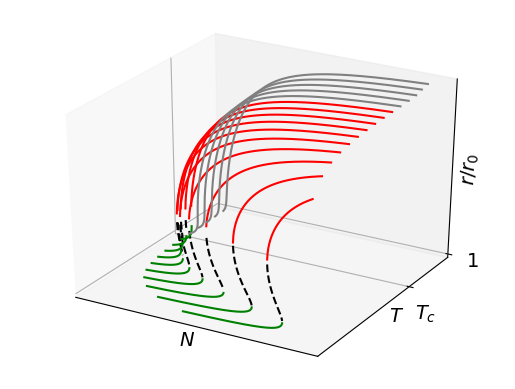

Tc = 478.0


In [48]:
fig = plt.figure()
soln_colors = Dict("small" => "g", "medium" => "k", "large" => "r")
soln_linestyle = Dict("small" => nothing, "medium" => "--", "large" => nothing)

Tc = NaN
found_gray = false
for i = 1:length(T_span)
    for soln in ["small", "large", "medium"]
        idx = (df_3d_bifur[:which_soln] .== soln) .& (df_3d_bifur[:T] .== T_span[i])
        
        if length(unique(df_3d_bifur[df_3d_bifur[:T] .== T_span[i], :][:which_soln])) == 3
            plt.plot3D(df_3d_bifur[:N][idx], [T_span[i] for kk = 1:sum(idx)],
                       df_3d_bifur[:r][idx] / balloon.r₀, color=soln_colors[soln],
                       linestyle=soln_linestyle[soln])
        else
            if ! found_gray
                Tc = T_span[i]
                    println("Tc = ", Tc)
            end
            found_gray = true
            plt.plot3D(df_3d_bifur[:N][idx], [T_span[i] for kk = 1:sum(idx)],
                df_3d_bifur[:r][idx] / balloon.r₀, color="0.5",
                linestyle=soln_linestyle[soln])
        end
    end
end

plt.xlabel("\$N\$", labelpad=-13)
plt.ylabel("\$T\$", labelpad=-13)
plt.zlabel("\$r/r_0\$", labelpad=-13)
plt.zlim(zmin=1)

plt.zticks([1])
plt.yticks([Tc], ["\$T_c\$"])
plt.xticks([])

plt.savefig("3d_bifurcation.png", format="png", dpi=300)
plt.show()

In [49]:
length(unique(df_3d_bifur[df_3d_bifur[:T] .== T_span[1], :][:which_soln]))

3

┌ Warning: User must amend balloon.ρkT for different temperatures; use plt.figure() before this
└ @ Main In[44]:37


r/r₀ = 1.012307, N/Na = 0.940134. G = 0.015214 bar-m3
min G = 1.000000 at r/r₀ = 1.013033, ϕ = 0.940472


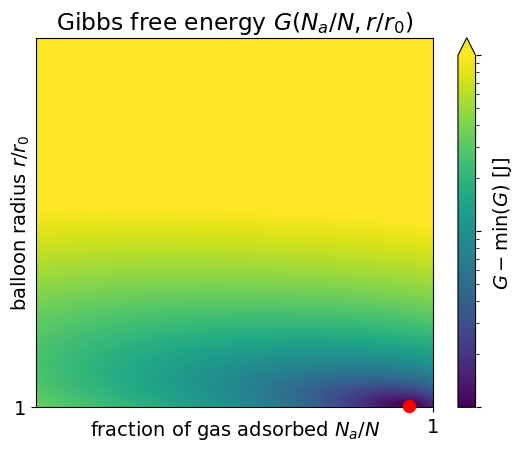

See Gibbs_in_plane


PyObject <matplotlib.collections.QuadMesh object at 0x7f4e68be0780>

In [50]:
new_system = deepcopy(system)
new_system.T = 500.0
new_system.N = system.N*0.01
hot_cold_balloon = new_balloon(balloon, system.T, new_system.T)

plot_Gibbs_free_energy(hot_cold_balloon, adsorbent, new_system, 
                      savename="Gibbs_in_plane", 
                      ϕ_min=0.01, vmax=1.0, r_ovr_r₀_max=6.2)

# breathing MOF example
narrow pore (np) and large pore (lp)

In [ ]:
_fontsize = 16

K = Dict("np" => 5.0, "lp" => 10.0, "1" => 25.0, "2" => 3.5)
M = Dict("np" => 0.6, "lp" => 1.0, "1" => 1., "2"=> 1.75)

P = collect(range(0, stop=1.0, length=100))

N = Dict(ps => M[ps] * K[ps] * P ./ (1.0 .+ K[ps] * P) for ps in ["np", "lp", "1", "2"])
N_total = Dict("1" => 1.4, "2" => 1.4)

P_loop = [0.175, 0.425]
P_mid = mean(P_loop)

idx_lp = P .> minimum(P_loop)
idx_np = P .< maximum(P_loop);

P_opt = Dict(which_phase =>
        solve_two_adsorbents(LangmuirAdsorbent(K["2"], 298.0, M["2"], 0.0),
                             LangmuirAdsorbent(K[which_phase], 298.0, M[which_phase], 0.0), 
                             N_total["2"], 298.0) for which_phase in ["np", "lp"]
)


In [ ]:
for which_mof in ["2", "1"]
    fig, ax = mathy_figure()

    plt.plot(P[idx_lp], N["lp"][idx_lp],
            color="C0", lw=3, label="\$N_1(P)\$")
    plt.plot(P[idx_np], N["np"][idx_np],
            color="C0", lw=3)
    plt.plot([P_mid, P_mid], 
         [M[ph] * K[ph] * P_mid / (1 + K[ph] * P_mid) for ph in ["lp", "np"]],
    color="C0", lw=3, linestyle=":")
    
    plt.plot(P, N_total[which_mof] .- N[which_mof], label="\$N-N_2(P)\$",
            color="C1", lw=3)
    plt.axhline(N_total[which_mof], color="k", linestyle="--", lw=3, xmin=0.045)
    # plt.plot(r_ovr_r_0, P_minus_P0_autodiff, color="k", linestyle="--")
    plt.xlabel("pressure, \$P\$", fontsize=18, labelpad=-15)
    plt.ylabel("moles of gas", fontsize=18, labelpad=-15)
    plt.yticks([0, N_total[which_mof]], ["\$0\$", "\$N\$"], fontsize=18)
    plt.xticks([0], ["\$0\$"], fontsize=18)
    if which_mof == "2"
        for which_phase in ["np", "lp"]
            plt.scatter([P_opt[which_phase]], 
                [M[which_phase] * K[which_phase] * P_opt[which_phase] / (1.0 + K[which_phase] * P_opt[which_phase])],
                marker="x", color="r", 
                zorder=1000, s=150)
               # label=which_phase == "np" ? "equilibrium (meta)" : nothing)
        end
    end
    plt.scatter([P_mid], 
            [N_total[which_mof] - M[which_mof] * K[which_mof] * P_mid / (1.0 + K[which_mof] * P_mid)],
            marker="*", color="r", 
            zorder=1000, s=150)
    # plt.axvline(x=system.P₀, linestyle=":", color="k")
    #plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop=Dict("size" => 10))
   # plt.legend(loc="best", prop=Dict("size" => 16))

    # plt.title("Pressure-radius characteristic of balloon")
    plt.tight_layout()
    if which_mof == "1"
        plt.savefig("dual_adsorbent_breathing_no_soln.png", format="png", dpi=300)
    else
        plt.savefig("dual_adsorbent_breathing_two_soln.png", format="png", dpi=300)
    end
    plt.show()
end

a negative gas adsorption MOF

In [ ]:
K = Dict("liq" => 40.0,"gas" => 0.1, "1" => 5.0)
M = Dict("liq" => 1.0, "gas" => 1.0, "1" => 1.4)

P = range(0, stop=1.0, length=200)

N = Dict(ps => M[ps] * K[ps] * P ./ (1.0 .+ K[ps] * P) for ps in ["liq", "gas", "1"])
N_total = 1.4

P_phase_transition = 0.3

In [ ]:
fig, ax = mathy_figure()

plt.plot(P[P .< P_phase_transition], 
         N["gas"][P .< P_phase_transition],
         color="C0", lw=3, label="\$N_1(P)\$")
plt.plot(P[P .> P_phase_transition], N["liq"][P .> P_phase_transition],
    color="C0", lw=3)
plt.plot([P_phase_transition, P_phase_transition], 
         [M[ph] * K[ph] * P_phase_transition / (1 .+ K[ph] * P_phase_transition) for ph in ["gas", "liq"]],
    color="C0", lw=3, linestyle=":")
plt.xticks([0], ["\$0\$"], fontsize=18)
plt.plot(P, N_total .- N["1"], label="\$N-N_2(P)\$",
        color="C1", lw=3)
plt.axhline(N_total, color="k", linestyle="--", lw=3, xmin=0.045)
# plt.plot(r_ovr_r_0, P_minus_P0_autodiff, color="k", linestyle="--")
plt.xlabel("pressure, \$P\$", fontsize=18, labelpad=-15)
plt.ylabel("moles of gas", fontsize=18, labelpad=-15)
plt.yticks([0, N_total], ["\$0\$", "\$N\$"], fontsize=18)

plt.scatter([P_phase_transition], 
    [N_total- M["1"] * K["1"] * P_phase_transition / (1.0 .+ K["1"] * P_phase_transition)],
    marker="*", color="r", 
    zorder=1000, s=150, label="equilibrium (coex.)")

# plt.axvline(x=system.P₀, linestyle=":", color="k")
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop=Dict("size" => 10))
# plt.legend(loc="center right", prop=Dict("size" => 14))

# plt.title("Pressure-radius characteristic of balloon")
plt.tight_layout()

plt.savefig("phase_transition_dual_adsorbent.png", format="png", dpi=300)
plt.show()